In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
    recall_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.patches as mpatches
import joblib
import os
import itertools

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/arcry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 150)

# Загрузка и предобработка данных 

In [4]:
path = os.path.abspath(os.getcwd())
path = os.path.dirname(path)
path

'/home/arcry/work/insurance_model'

In [2]:
data = pd.read_csv('../data/interim/prepared_data.csv')

In [33]:
test = pd.read_csv('../data/interim/dataset_insurance_no_clean.csv')

In [3]:
data.groupby('target').count()

text
target      
0       2593
1       3615

In [89]:
test.groupby('target').count()

text
target       
0        4300
1       37569

In [4]:
def get_most_important_features(vectorizer, model, n=5):
    '''fuction shows most important words'''
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    # area under the ROC curve
    roc_auc = roc_auc_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, roc_auc

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    '''plot most important words in classification'''
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Не Осаго/Каско', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Осаго/Каско', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt


def plot_LSA(test_data, test_labels, plot=True):
        '''plot 2D class distribution'''
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Не Осаго/Каско')
            blue_patch = mpatches.Patch(color='blue', label='Осаго/Каско')
            green_patch = mpatches.Patch(color='red', label='Shops B-Days')
            plt.legend(handles=[red_patch, blue_patch], prop={'size': 30})

In [29]:
test_size = 0.2
data['tokens'] = data.text.str.split()
data_train, data_test = train_test_split(
    	data, test_size=test_size, random_state=42)

X_train = data_train["text"]
y_train = data_train["target"]

X_test = data_test["text"]
y_test = data_test["target"]

## BOW 

In [78]:
# use bag of words vectorizer method
def cv(data):
#     count_vectorizer = CountVectorizer(max_features=15000, max_df=0.9, min_df=5, ngram_range=(1,2))
    count_vectorizer = CountVectorizer(analyzer='char', ngram_range =(3,5), max_df=0.8, min_df=2)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [79]:
# vectorize texts
X_train_counts, count_vectorizer = cv(data_train["text"])
X_test_counts = count_vectorizer.transform(data_test["text"])

In [80]:
# # save vectorizer (saved)
# joblib.dump(count_vectorizer, path + '/models/vectorizer.joblib')

In [81]:
# count_vectorizer = joblib.load(path + '/models/vectorizer.joblib')

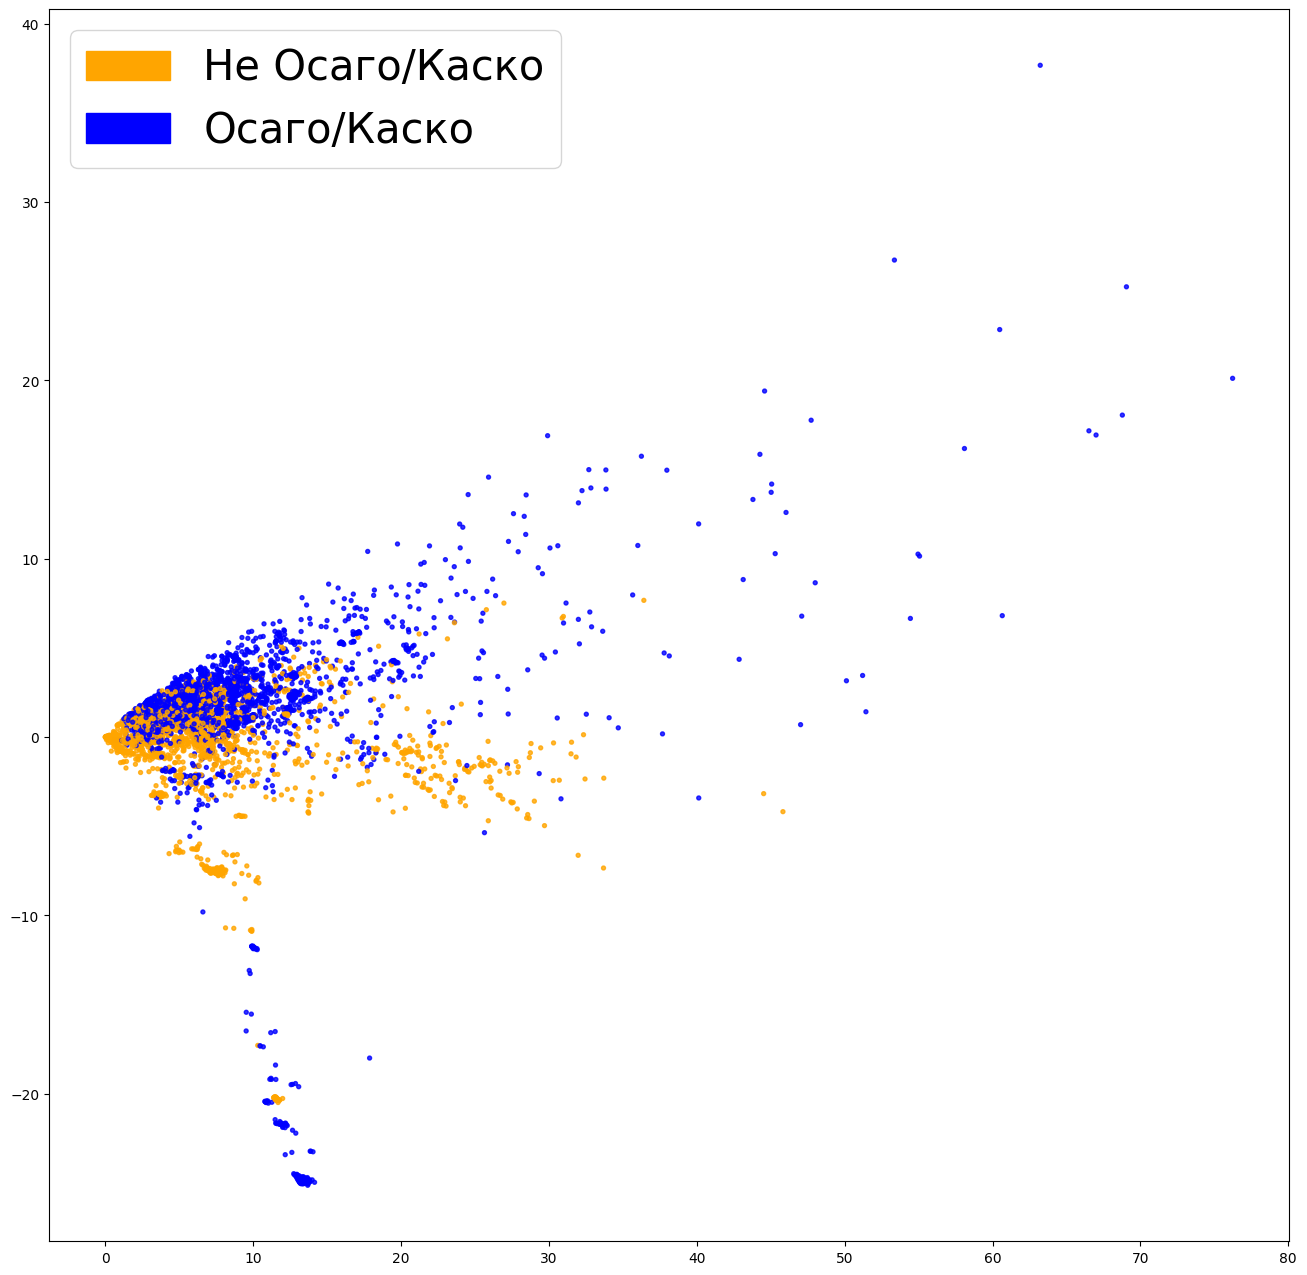

In [82]:
# plot distribution
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

### Log Reg

In [83]:
# use logistic regression classifier 
clf = LogisticRegression(C=0.5, l1_ratio=0.02,
                         multi_class='auto', random_state=40, max_iter=1000)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/home/arcry/anaconda3/envs/nerenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [15]:
# save classifier (saved)
joblib.dump(clf, path + '/models/clf.joblib')

['/home/arcry/work/insurance_model/models/clf.joblib']

In [84]:
# predict test
y_predicted_counts = clf.predict(X_test_counts)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.984, precision = 0.984, recall = 0.984, f1 = 0.984,  roc_auc = 0.984


In [62]:
# predict train
y_train_pred = clf.predict(X_train_counts)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_train, y_train_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 1.000, precision = 1.000, recall = 1.000, f1 = 1.000,  roc_auc = 1.000


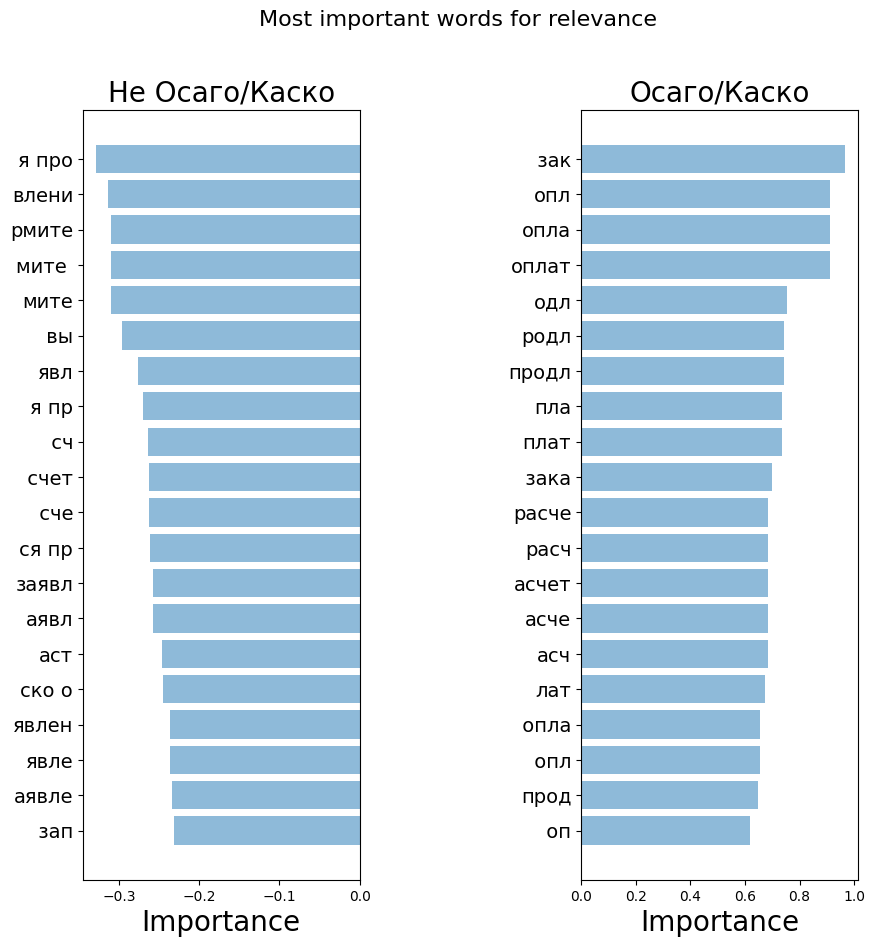

In [85]:
# plot most important words
importance = get_most_important_features(count_vectorizer, clf, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

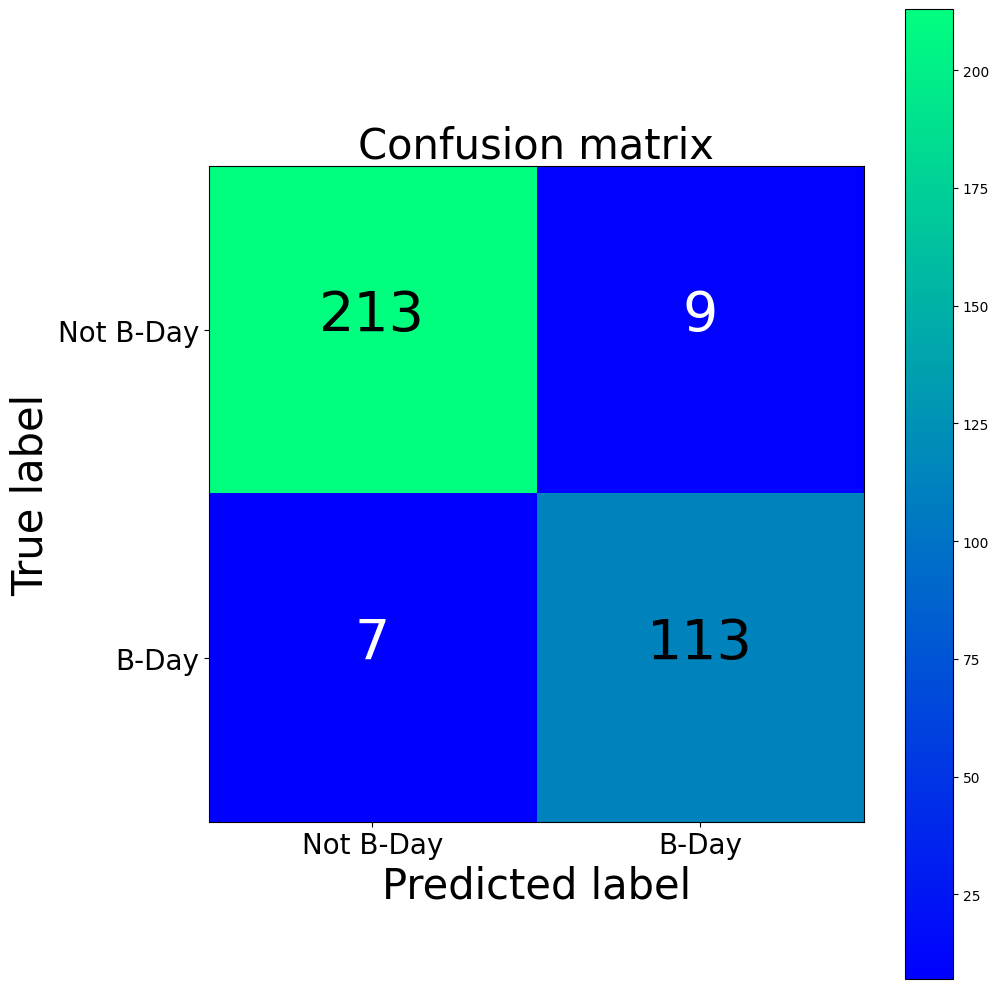

In [19]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

In [1]:
# plot confusion matrix for threshold = 0.8
y_predicted_counts_proba = clf.predict_proba(X_test_counts)
y_proba = np.array([1 if x >= 0.55 else 0 for x in y_predicted_counts_proba[:,1]])

cm2 = confusion_matrix(y_test, y_proba)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

NameError: name 'clf' is not defined

### SVM

In [43]:
# use SVM classifier 
clf_svc = SVC(C=0.06, probability=True, random_state=40, kernel='linear', verbose=2)
clf_svc.fit(X_train_counts, y_train)

[LibSVM]

SVC(C=0.06, kernel='linear', probability=True, random_state=40, verbose=2)

In [44]:
# predict test
y_predicted_counts_svc = clf_svc.predict(X_test_counts)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_test, y_predicted_counts_svc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.963, precision = 0.964, recall = 0.963, f1 = 0.963,  roc_auc = 0.965


In [57]:
# predict train
y_train_pred_svc = clf_svc.predict(X_train_counts)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_train, y_train_pred_svc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.997, precision = 0.997, recall = 0.997, f1 = 0.997,  roc_auc = 0.997


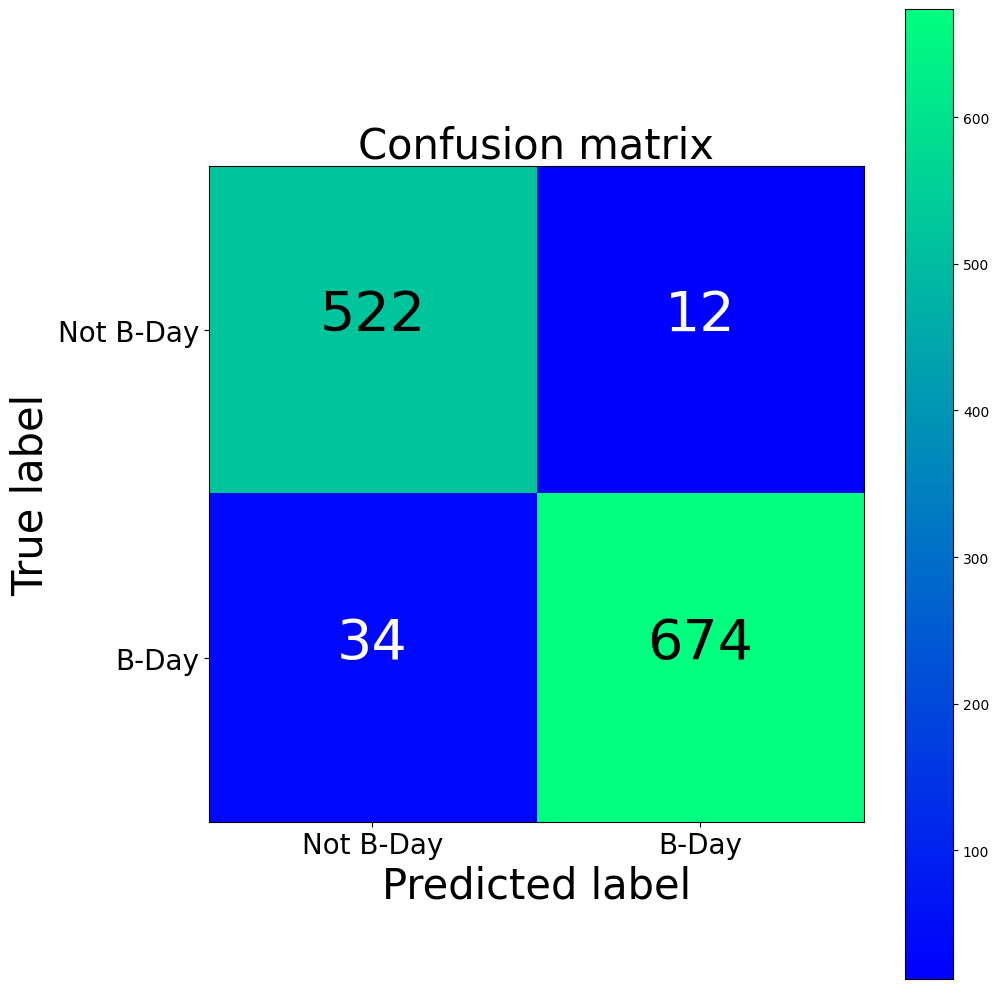

In [45]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(y_test, y_predicted_counts_svc)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

### SGD

In [59]:
# use SGD classifier 
clf_sgd = SGDClassifier(loss='log', alpha=0.0001, max_iter=5000, tol=1e-3, verbose=2, random_state=40)
clf_sgd.fit(X_train_counts, y_train)

-- Epoch 1
Norm: 23.13, NNZs: 8901, Bias: -2.555650, T: 28832, Avg. loss: 0.117929
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 18.82, NNZs: 8901, Bias: -2.692096, T: 57664, Avg. loss: 0.016936
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 18.00, NNZs: 8901, Bias: -2.767434, T: 86496, Avg. loss: 0.016712
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 17.66, NNZs: 8901, Bias: -2.820694, T: 115328, Avg. loss: 0.016527
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 17.45, NNZs: 8901, Bias: -2.862725, T: 144160, Avg. loss: 0.016546
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 17.38, NNZs: 8901, Bias: -2.893230, T: 172992, Avg. loss: 0.016525
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 17.29, NNZs: 8901, Bias: -2.920554, T: 201824, Avg. loss: 0.016399
Total training time: 0.03 seconds.
Convergence after 7 epochs took 0.03 seconds


SGDClassifier(loss='log', max_iter=5000, random_state=40, verbose=2)

In [60]:
# predict test
y_predicted_counts_sgd = clf_sgd.predict(X_test_counts)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_test, y_predicted_counts_sgd)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.997, precision = 0.997, recall = 0.997, f1 = 0.997,  roc_auc = 0.996


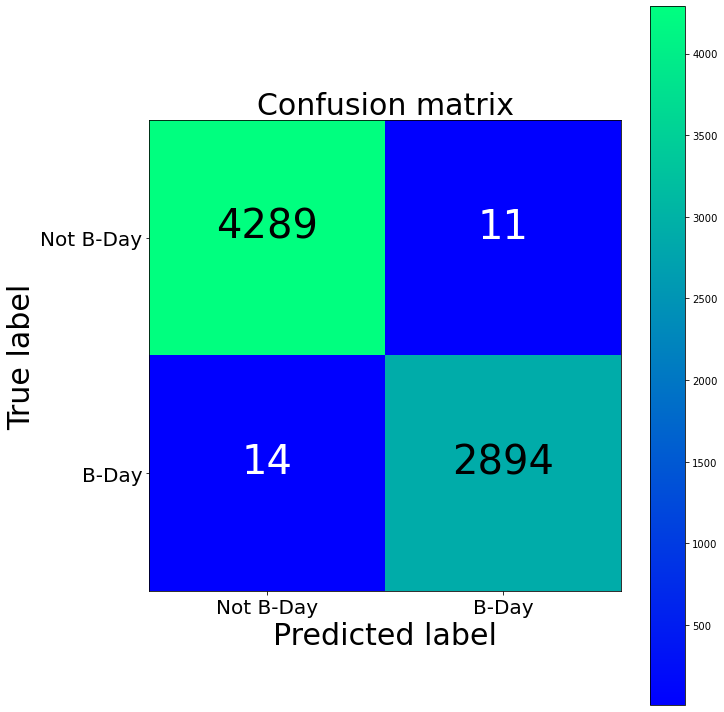

In [61]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(y_test, y_predicted_counts_sgd)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

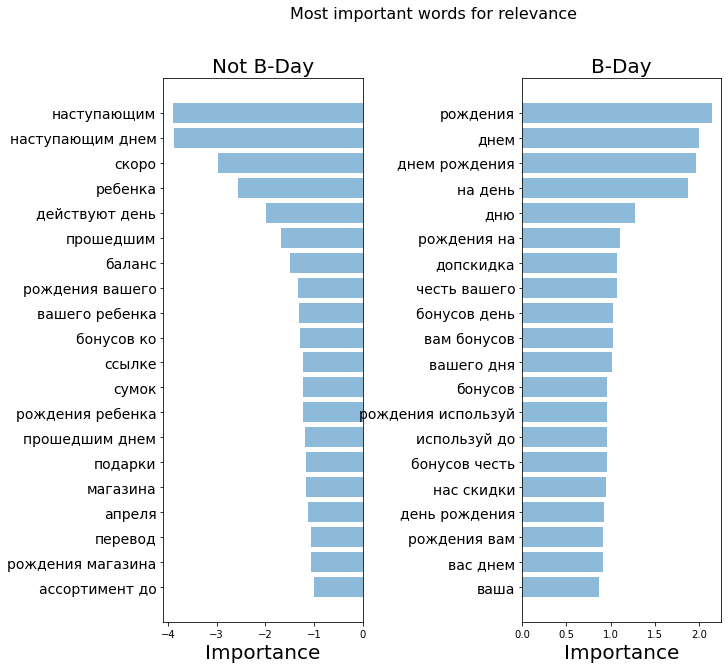

In [62]:
importance = get_most_important_features(count_vectorizer, clf_sgd, 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

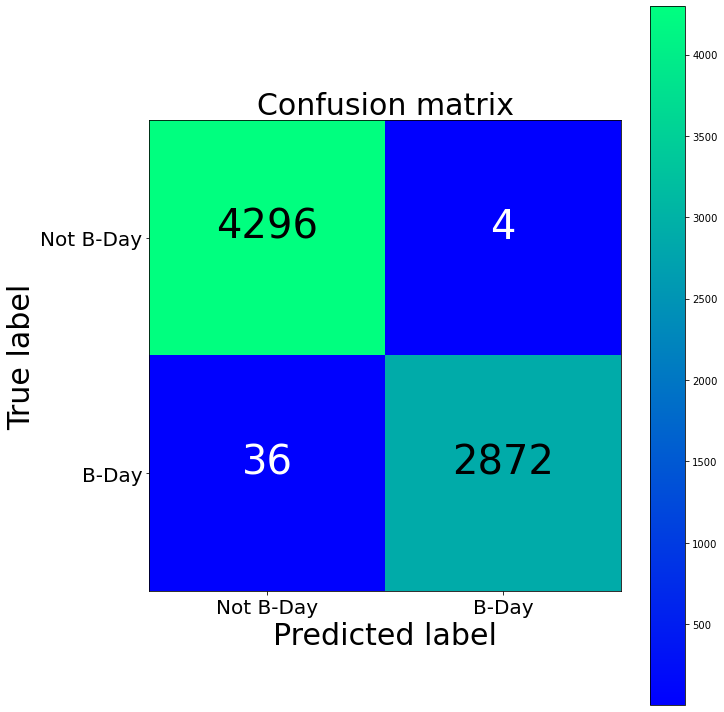

In [63]:
# plot confusion matrix for threshold = 0.8
y_predicted_counts_proba = clf_sgd.predict_proba(X_test_counts)
y_proba = np.array([1 if x >= 0.8 else 0 for x in y_predicted_counts_proba[:,1]])

cm2 = confusion_matrix(y_test, y_proba)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char', ngram_range =([2,5]))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=3,C=1e6, solver='lbfgs', 
                                           multi_class='auto',
                                           max_iter=1000,
                                           random_state=42)),
])

# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)



# from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score
# print(classification_report(y_test, y_pred))
# print(f"F1 Score: {f1_score(y_test, y_pred)}")

### CV

In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

In [12]:
cv = StratifiedKFold(shuffle=True, random_state=42)

In [9]:
logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char')),
#                 ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, 
                                           multi_class='auto',
                                           max_iter=1000,
                                           random_state=42)),
])

In [23]:
params = {'vect__ngram_range': [(3, 5)],
          'vect__max_df': [0.8],
          'vect__min_df': [3],
          'clf__C': [0.5],
          'clf__solver': ['lbfgs'],
          'clf__l1_ratio': [0.02]
          }

In [24]:
r_search = RandomizedSearchCV(estimator=logreg, param_distributions=params, n_iter=15, cv=cv, verbose=5, n_jobs=-1)

In [25]:
r_search.fit(data.text, data.target)

/home/arcry/anaconda3/envs/nerenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/arcry/anaconda3/envs/nerenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(analyzer='char')),
                                             ('clf',
                                              LogisticRegression(max_iter=1000,
                                                                 n_jobs=-1,
                                                                 random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__C': [0.5],
                                        'clf__l1_ratio': [0.02],
                                        'clf__solver': ['lbfgs'],
                                        'vect__max_df': [0.8],
                                        'vect__min_df': [3],
                                        'vect__ngram_range': [(3, 5)]},
                   verbose=5)

In [26]:
r_search.best_params_

{'vect__ngram_range': (3, 5),
 'vect__min_df': 3,
 'vect__max_df': 0.8,
 'clf__solver': 'lbfgs',
 'clf__l1_ratio': 0.02,
 'clf__C': 0.5}

In [28]:
r_search.best_score_

0.983891879827836

In [30]:
best_estimator = r_search.best_estimator_
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
best_estimator.score(X_test, y_test)



/home/arcry/anaconda3/envs/nerenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0.9855072463768116

In [34]:
roc_auc_score(test.target, r_search.predict(test.text))

0.9957439087273215

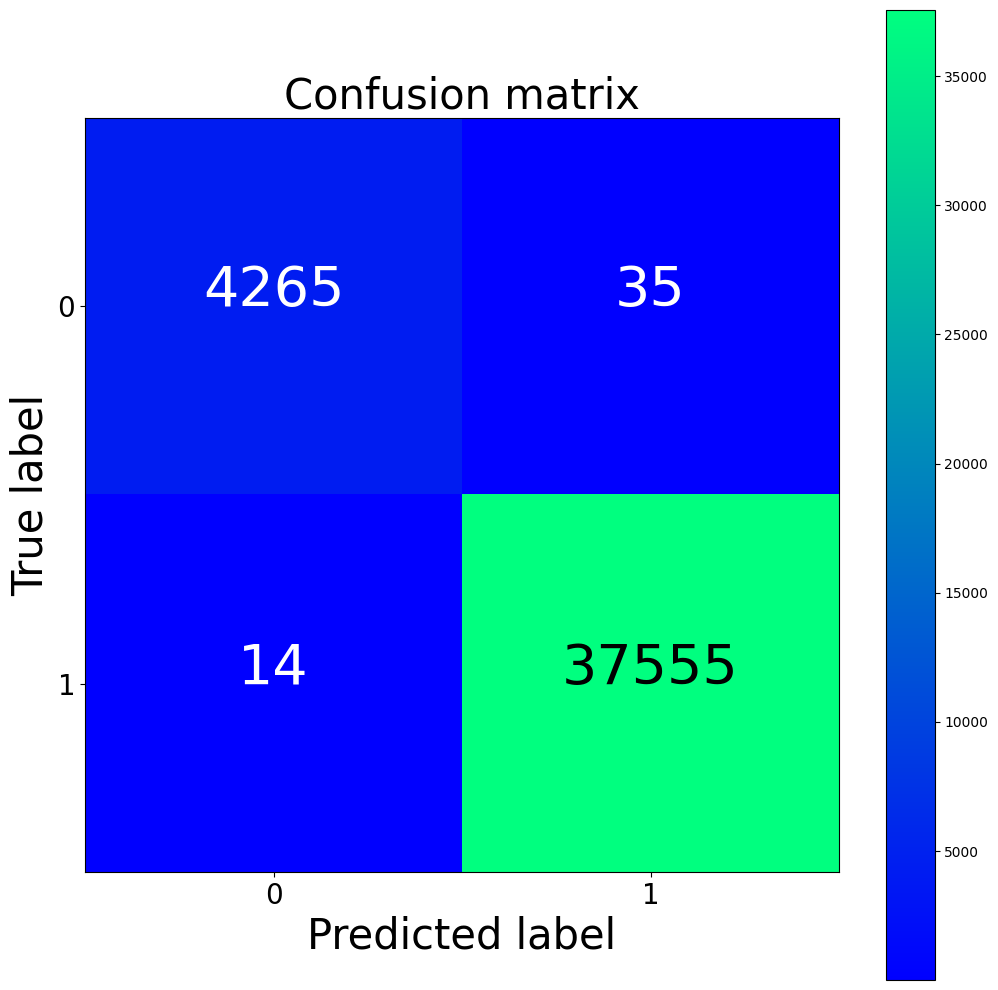

In [35]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(test.target, r_search.predict(test.text))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       534
           1       0.99      0.99      0.99       708

    accuracy                           0.99      1242
   macro avg       0.99      0.99      0.99      1242
weighted avg       0.99      0.99      0.99      1242

F1 Score: 0.9872881355932204
ROC AUC: 0.9852171015044754


In [56]:
logreg.

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [43]:
# plot most important words
importance = get_most_important_features(logreg[0], logreg[1], 20)
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

AttributeError: 'CountVectorizer' object has no attribute 'vocabulary_'

### Catboost

In [69]:
from catboost import CatBoostClassifier, Pool
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='TotalF1', od_type='Iter', 
                               od_wait=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

In [70]:
pd.DataFrame(data_train.text)

text
724                                                                 добрый день напоминаем окончании сроков действия каско осаго ждем автосалоне продление 
765                                                                                расторжения полиса осаго направьте селфи паспортом подготовки соглашения
286                                                                                                                                                        
3217             добрый день анатолий викторович напоминаем окончании полиса -осаго ждем адресу гранд сити новый проезд запись уважением магазин страховок 
307                                                                                                                                    чехов чехова аэнком 
...                                                                                                                                                     ...
3772  александр спасибо обращение войковской адресу москва метро войковская новопетровский проезд каждому покупателю каско комплект зимней резины подаро...
5191  уважаемый ольга олеговна действие вашего полиса каско заканчивается продления договора можете обратиться персонального менеджера солнышкина анна у...
5226  дмитрий владимирович добрый день наступающим новым годом напоминаем заканчивается полис осаго вашего автомобиля возможно оформление визита автосал...
5390             перевод анна владимировна баланс сообщение полис осаго сообщаем заключении договора осаго спао ингосстрах срок страх период использования 
860    барнаул проспект ленина телефон - обед выходной необходимые документы полис осаго паспорт заявителя извещение банковские реквизиты собственника з...

[4966 rows x 1 columns]

In [71]:
train_pool = Pool(data=pd.DataFrame(data_train.text), label=y_train, 
                  text_features=['text'])
valid_pool = Pool(data=pd.DataFrame(data_test.text), label=y_test, 
                  text_features=['text'])
test_pool = Pool(data=pd.DataFrame(test.text),
                  text_features=['text'])

In [72]:
data

text  \
0                                                                                       каско акции сохранили расчет прошлого года позвоним ближайшее время   
1                                                                                                напоминаем окончании полиса осаго быстрое продление ссылке   
2               срок вашего полиса подходит концу цены снижены сможете продлить полис осаго каско выгодных условиях центр бутово доставим полисы бесплатно    
3                                                        олег олегович напоминаем окончании полиса каско быстрое продление ссылке коржаков личном кабинете    
4     срок вашего полиса подходит концу цены снижены сможете продлить полис осаго каско выгодных условиях подольск доставим полисы бесплатно будьте осто...   
...                                                                                                                                                     ...   
6203  борисовна баланс сообщение каско сергей анатольевич продлите полис осаго вашего агента доступа сайту электронного осаго осталось всего дней оконча...   
6204   дельта - - - аэнком - - цитадель-эксперт - - аксиома - - тентоинвестсервис - - - - заявите происшествие мобильном приложении необходимые документ...   
6205  адрес генерала белова корп домодедовская контакты телефон - - - - время работы - обед - заявите происшествие мобильном приложении необходимые доку...   
6206                                                                                                     ссылка оплату осаго компании ингосстрах стоимость    
6207  рассмотрели заявку стоимость полиса осаго корректна предварительном расчете стоимость является окончательным окончательная стоимость формируется о...   

      target  \
0          1   
1          1   
2          1   
3          1   
4          1   
...      ...   
6203       1   
6204       0   
6205       0   
6206       1   
6207       1   

                                                                                                                                                     tokens  
0                                                                             [каско, акции, сохранили, расчет, прошлого, года, позвоним, ближайшее, время]  
1                                                                                        [напоминаем, окончании, полиса, осаго, быстрое, продление, ссылке]  
2     [срок, вашего, полиса, подходит, концу, цены, снижены, сможете, продлить, полис, осаго, каско, выгодных, условиях, центр, бутово, доставим, полисы...  
3                                            [олег, олегович, напоминаем, окончании, полиса, каско, быстрое, продление, ссылке, коржаков, личном, кабинете]  
4     [срок, вашего, полиса, подходит, концу, цены, снижены, сможете, продлить, полис, осаго, каско, выгодных, условиях, подольск, доставим, полисы, бес...  
...                                                                                                                                                     ...  
6203  [борисовна, баланс, сообщение, каско, сергей, анатольевич, продлите, полис, осаго, вашего, агента, доступа, сайту, электронного, осаго, осталось, ...  
6204  [дельта, -, -, -, аэнком, -, -, цитадель-эксперт, -, -, аксиома, -, -, тентоинвестсервис, -, -, -, -, заявите, происшествие, мобильном, приложении...  
6205  [адрес, генерала, белова, корп, домодедовская, контакты, телефон, -, -, -, -, время, работы, -, обед, -, заявите, происшествие, мобильном, приложе...  
6206                                                                                               [ссылка, оплату, осаго, компании, ингосстрах, стоимость]  
6207  [рассмотрели, заявку, стоимость, полиса, осаго, корректна, предварительном, расчете, стоимость, является, окончательным, окончательная, стоимость,...  

[6208 rows x 3 columns]

In [73]:
cv.split(data.text, data.target)


<generator object _BaseKFold.split at 0x7f7577111890>

In [74]:
import pandas as pd

data = data[['text', 'target']]
X = data.text
y = data.target

cat = CatBoostClassifier(iterations=1000,
                               depth=3,
                               learning_rate=1,
                               loss_function='Logloss',
                               eval_metric='TotalF1', od_type='Iter',
                               verbose=True)

scores = []
k = 0
for train_index, test_index in cv.split(data.text, data.target):
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_pool = Pool(data=pd.DataFrame(X_train), label=y_train, 
                  
                  text_features=['text']
                 )
    valid_pool = Pool(data=pd.DataFrame(X_test), label=y_test,
                  
                  text_features=['text']
                 )
    
    cat.fit(train_pool, eval_set=valid_pool, plot=True)
    y_pred = cat.predict(valid_pool)
    score = f1_score(y_test, y_pred, average="weighted")
    res = X_test.copy()
    res['predict'] = y_pred
    res['target'] = y_test 
#     res.to_csv(f'../data/folds/test_fold{k}.csv')
    scores.append(score)
    k += 1
#     pd.DataFrame(y_test, y_pred, X_test)
    
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9077688	test: 0.9332666	best: 0.9332666 (0)	total: 7.23ms	remaining: 7.22s
1:	learn: 0.9170754	test: 0.9364184	best: 0.9364184 (1)	total: 14.9ms	remaining: 7.45s
2:	learn: 0.9232354	test: 0.9356221	best: 0.9364184 (1)	total: 21.8ms	remaining: 7.24s
3:	learn: 0.9303947	test: 0.9427943	best: 0.9427943 (3)	total: 29.1ms	remaining: 7.26s
4:	learn: 0.9324233	test: 0.9427943	best: 0.9427943 (3)	total: 36.1ms	remaining: 7.18s
5:	learn: 0.9333932	test: 0.9435587	best: 0.9435587 (5)	total: 42.4ms	remaining: 7.02s
6:	learn: 0.9363802	test: 0.9443566	best: 0.9443566 (6)	total: 49.1ms	remaining: 6.96s
7:	learn: 0.9389704	test: 0.9451547	best: 0.9451547 (7)	total: 55.6ms	remaining: 6.89s
8:	learn: 0.9425592	test: 0.9467514	best: 0.9467514 (8)	total: 62.2ms	remaining: 6.85s
9:	learn: 0.9453527	test: 0.9467514	best: 0.9467514 (8)	total: 68.9ms	remaining: 6.82s
10:	learn: 0.9477646	test: 0.9524064	best: 0.9524064 (10)	total: 75.4ms	remaining: 6.78s
11:	learn: 0.9497814	test: 0.9524064	best

114:	learn: 0.9965778	test: 0.9790717	best: 0.9790717 (102)	total: 809ms	remaining: 6.22s
115:	learn: 0.9969804	test: 0.9790717	best: 0.9790717 (102)	total: 816ms	remaining: 6.22s
116:	learn: 0.9971816	test: 0.9790717	best: 0.9790717 (102)	total: 824ms	remaining: 6.21s
117:	learn: 0.9971816	test: 0.9790717	best: 0.9790717 (102)	total: 833ms	remaining: 6.22s
118:	learn: 0.9971816	test: 0.9790717	best: 0.9790717 (102)	total: 840ms	remaining: 6.21s
119:	learn: 0.9973828	test: 0.9790717	best: 0.9790717 (102)	total: 847ms	remaining: 6.21s
120:	learn: 0.9975842	test: 0.9790717	best: 0.9790717 (102)	total: 854ms	remaining: 6.2s
121:	learn: 0.9975842	test: 0.9790717	best: 0.9790717 (102)	total: 861ms	remaining: 6.19s
122:	learn: 0.9977855	test: 0.9790717	best: 0.9790717 (102)	total: 869ms	remaining: 6.19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9790716542
bestIteration = 102

Shrink model to first 103 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9085709	test: 0.9316908	best: 0.9316908 (0)	total: 8.66ms	remaining: 8.65s
1:	learn: 0.9149152	test: 0.9348746	best: 0.9348746 (1)	total: 16.5ms	remaining: 8.23s
2:	learn: 0.9192651	test: 0.9364015	best: 0.9364015 (2)	total: 23.8ms	remaining: 7.9s
3:	learn: 0.9218612	test: 0.9371981	best: 0.9371981 (3)	total: 30.9ms	remaining: 7.69s
4:	learn: 0.9278755	test: 0.9396053	best: 0.9396053 (4)	total: 38.6ms	remaining: 7.69s
5:	learn: 0.9308395	test: 0.9452036	best: 0.9452036 (5)	total: 45.9ms	remaining: 7.6s
6:	learn: 0.9340483	test: 0.9460016	best: 0.9460016 (6)	total: 52.2ms	remaining: 7.41s
7:	learn: 0.9358404	test: 0.9460016	best: 0.9460016 (6)	total: 59.7ms	remaining: 7.4s
8:	learn: 0.9380235	test: 0.9499940	best: 0.9499940 (8)	total: 66.7ms	remaining: 7.34s
9:	learn: 0.9392150	test: 0.9499940	best: 0.9499940 (8)	total: 74ms	remaining: 7.33s
10:	learn: 0.9428304	test: 0.9499786	best: 0.9499940 (8)	total: 80.8ms	remaining: 7.26s
11:	learn: 0.9438424	test: 0.9507930	best: 0.95

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9077455	test: 0.9332165	best: 0.9332165 (0)	total: 7.24ms	remaining: 7.23s
1:	learn: 0.9152877	test: 0.9403856	best: 0.9403856 (1)	total: 16.3ms	remaining: 8.14s
2:	learn: 0.9226391	test: 0.9459695	best: 0.9459695 (2)	total: 24.3ms	remaining: 8.06s
3:	learn: 0.9270130	test: 0.9459695	best: 0.9459695 (2)	total: 32.2ms	remaining: 8.02s
4:	learn: 0.9290194	test: 0.9459695	best: 0.9459695 (2)	total: 38.8ms	remaining: 7.72s
5:	learn: 0.9328003	test: 0.9483650	best: 0.9483650 (5)	total: 49.3ms	remaining: 8.16s
6:	learn: 0.9345792	test: 0.9475165	best: 0.9483650 (5)	total: 56.3ms	remaining: 7.99s
7:	learn: 0.9381647	test: 0.9515135	best: 0.9515135 (7)	total: 63.9ms	remaining: 7.92s
8:	learn: 0.9407560	test: 0.9507137	best: 0.9515135 (7)	total: 73.6ms	remaining: 8.11s
9:	learn: 0.9445461	test: 0.9507137	best: 0.9515135 (7)	total: 82.7ms	remaining: 8.18s
10:	learn: 0.9471414	test: 0.9507137	best: 0.9515135 (7)	total: 90.2ms	remaining: 8.11s
11:	learn: 0.9483559	test: 0.9499141	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9100255	test: 0.9292637	best: 0.9292637 (0)	total: 7.32ms	remaining: 7.31s
1:	learn: 0.9127964	test: 0.9268110	best: 0.9292637 (0)	total: 14.6ms	remaining: 7.28s
2:	learn: 0.9193682	test: 0.9324005	best: 0.9324005 (2)	total: 21ms	remaining: 6.99s
3:	learn: 0.9231335	test: 0.9363841	best: 0.9363841 (3)	total: 28.3ms	remaining: 7.06s
4:	learn: 0.9263409	test: 0.9371975	best: 0.9371975 (4)	total: 35ms	remaining: 6.96s
5:	learn: 0.9319108	test: 0.9379946	best: 0.9379946 (5)	total: 42.2ms	remaining: 6.99s
6:	learn: 0.9350952	test: 0.9419823	best: 0.9419823 (6)	total: 49.2ms	remaining: 6.97s
7:	learn: 0.9396757	test: 0.9499684	best: 0.9499684 (7)	total: 56.5ms	remaining: 7s
8:	learn: 0.9430709	test: 0.9548237	best: 0.9548237 (8)	total: 64.6ms	remaining: 7.11s
9:	learn: 0.9448689	test: 0.9556238	best: 0.9556238 (9)	total: 71.3ms	remaining: 7.06s
10:	learn: 0.9490551	test: 0.9572246	best: 0.9572246 (10)	total: 79ms	remaining: 7.1s
11:	learn: 0.9526631	test: 0.9604284	best: 0.960428

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9090183	test: 0.9226216	best: 0.9226216 (0)	total: 7.17ms	remaining: 7.17s
1:	learn: 0.9149782	test: 0.9242123	best: 0.9242123 (1)	total: 15ms	remaining: 7.49s
2:	learn: 0.9189445	test: 0.9297837	best: 0.9297837 (2)	total: 21.6ms	remaining: 7.17s
3:	learn: 0.9221242	test: 0.9297837	best: 0.9297837 (2)	total: 29.2ms	remaining: 7.27s
4:	learn: 0.9264977	test: 0.9337676	best: 0.9337676 (4)	total: 35.9ms	remaining: 7.15s
5:	learn: 0.9286773	test: 0.9321303	best: 0.9337676 (4)	total: 43ms	remaining: 7.12s
6:	learn: 0.9304675	test: 0.9345220	best: 0.9345220 (6)	total: 50.4ms	remaining: 7.15s
7:	learn: 0.9316772	test: 0.9345220	best: 0.9345220 (6)	total: 56.9ms	remaining: 7.05s
8:	learn: 0.9372588	test: 0.9369153	best: 0.9369153 (8)	total: 65.1ms	remaining: 7.17s
9:	learn: 0.9412697	test: 0.9418260	best: 0.9418260 (9)	total: 72.3ms	remaining: 7.16s
10:	learn: 0.9426866	test: 0.9426432	best: 0.9426432 (10)	total: 80ms	remaining: 7.19s
11:	learn: 0.9464786	test: 0.9450399	best: 0.94

100:	learn: 0.9967790	test: 0.9734193	best: 0.9742282 (86)	total: 724ms	remaining: 6.45s
101:	learn: 0.9967790	test: 0.9734193	best: 0.9742282 (86)	total: 732ms	remaining: 6.44s
102:	learn: 0.9969804	test: 0.9742282	best: 0.9742282 (86)	total: 739ms	remaining: 6.44s
103:	learn: 0.9969804	test: 0.9742282	best: 0.9742282 (86)	total: 747ms	remaining: 6.44s
104:	learn: 0.9969804	test: 0.9742282	best: 0.9742282 (86)	total: 754ms	remaining: 6.43s
105:	learn: 0.9969804	test: 0.9742282	best: 0.9742282 (86)	total: 761ms	remaining: 6.42s
106:	learn: 0.9969804	test: 0.9750368	best: 0.9750368 (106)	total: 768ms	remaining: 6.41s
107:	learn: 0.9969804	test: 0.9750368	best: 0.9750368 (106)	total: 775ms	remaining: 6.4s
108:	learn: 0.9969804	test: 0.9750368	best: 0.9750368 (106)	total: 782ms	remaining: 6.39s
109:	learn: 0.9969804	test: 0.9750368	best: 0.9750368 (106)	total: 789ms	remaining: 6.38s
110:	learn: 0.9971816	test: 0.9750368	best: 0.9750368 (106)	total: 796ms	remaining: 6.38s
111:	learn: 0.997

In [75]:
cat.predict(test_pool)

array([1, 1, 1, ..., 0, 0, 1])

In [76]:
roc_auc_score(test.target, cat.predict(test_pool))

0.9132270168855535

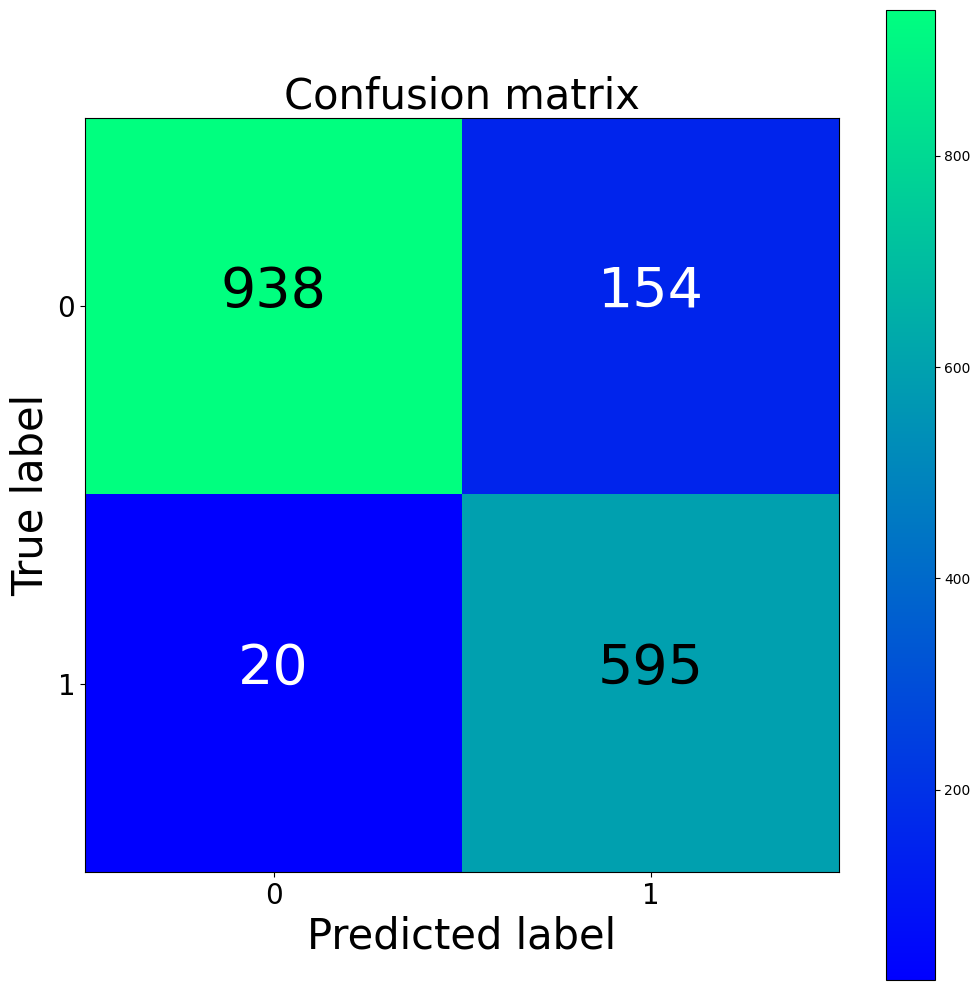

In [77]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(test.target, cat.predict(test_pool))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['0','1'], normalize=False, title='Confusion matrix')
plt.show()

## TF-IDF

In [46]:
# use tfidf vectorizer method
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(max_features=20000, max_df=0.4, min_df=5, stop_words='english', ngram_range=(1,2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


In [47]:
# vectorize train and test features
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

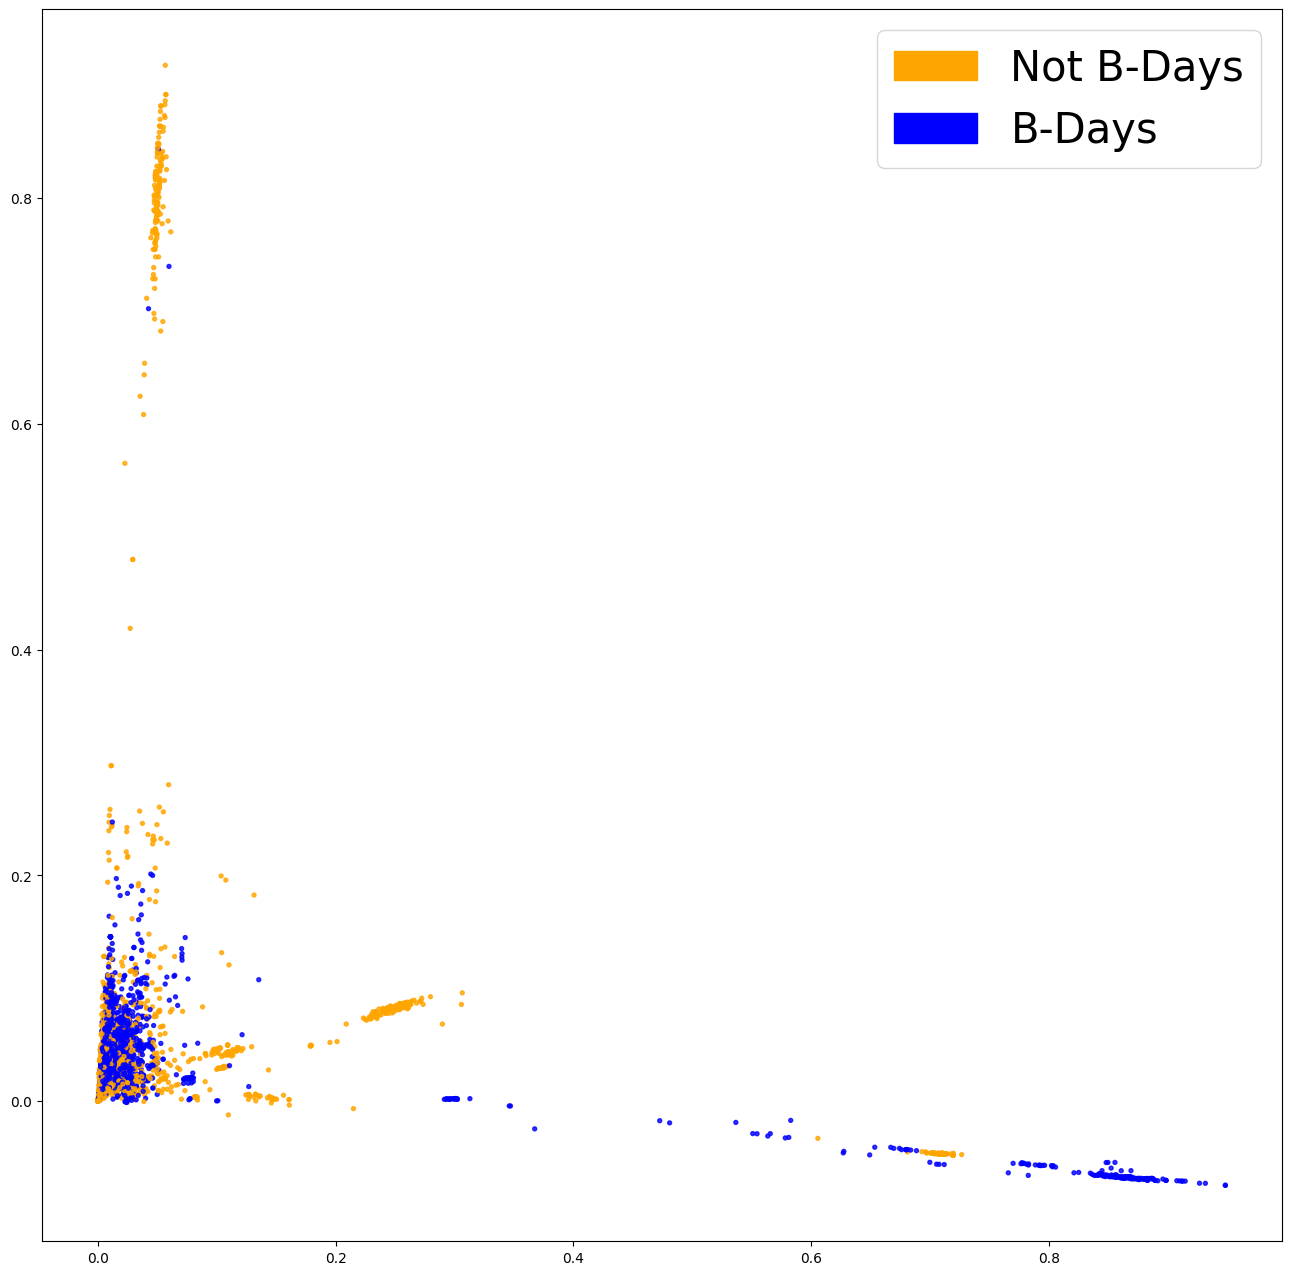

In [48]:
# plot distribution
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

### Log Reg

In [49]:
# use logistic regression classifier 
clf_tfidf = LogisticRegression(C=5, 
                         multi_class='ovr', random_state=40, max_iter=5000)
clf_tfidf.fit(X_train_tfidf, y_train)

# predict
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
y_train_pred = clf_tfidf.predict(X_train_tfidf)

In [50]:
# test
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, roc_auc = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf, roc_auc_tfidf))

accuracy = 0.958, precision = 0.958, recall = 0.958, f1 = 0.958, roc_auc = 0.957


In [51]:
# train
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, roc_auc_tfidf  = get_metrics(y_train, y_train_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, roc_auc = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf, roc_auc_tfidf ))

accuracy = 0.990, precision = 0.990, recall = 0.990, f1 = 0.990, roc_auc = 0.990


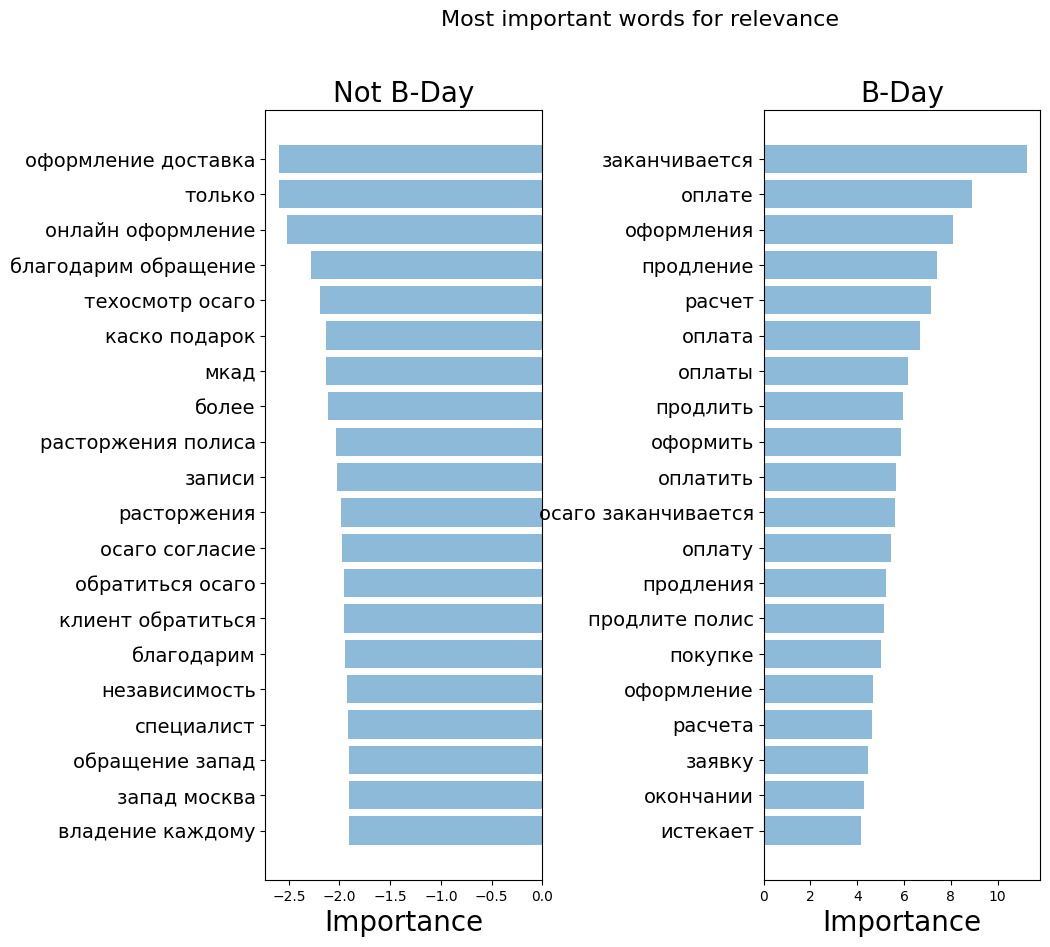

In [52]:
# plot most important words
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 20)
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


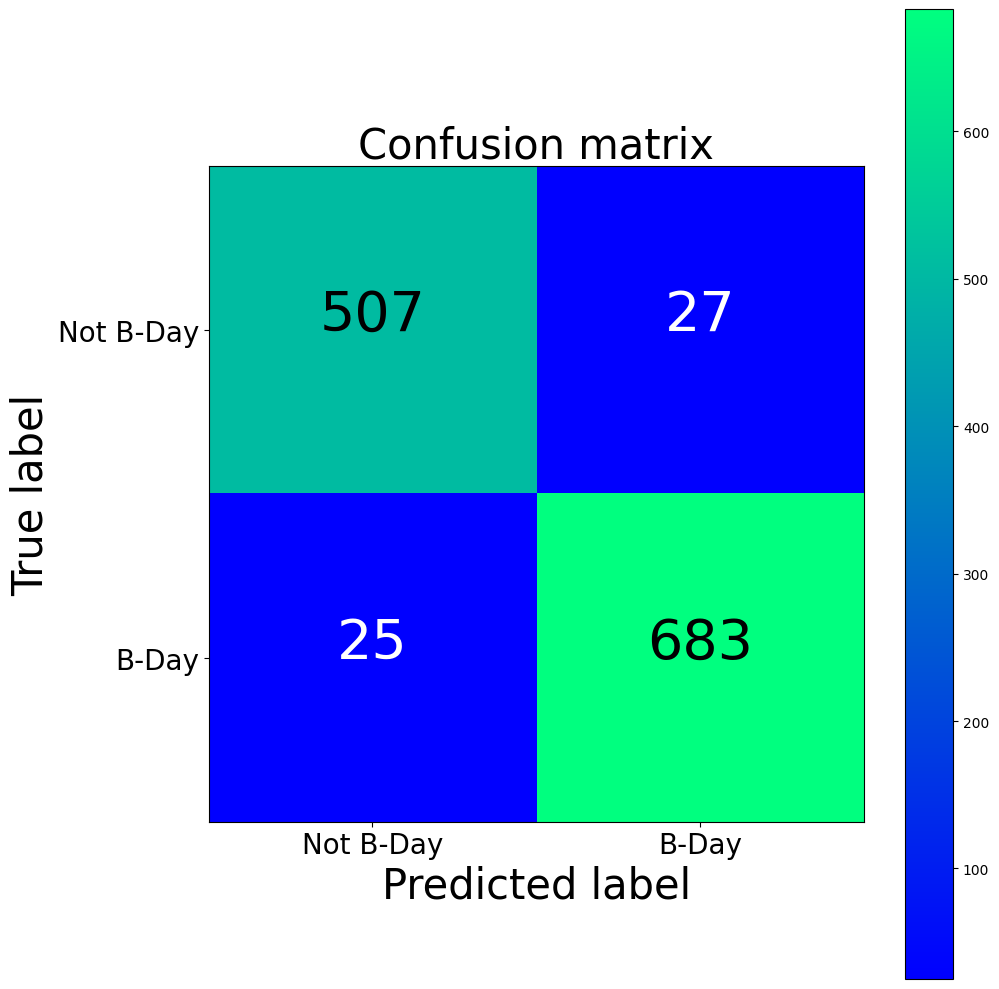

In [53]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

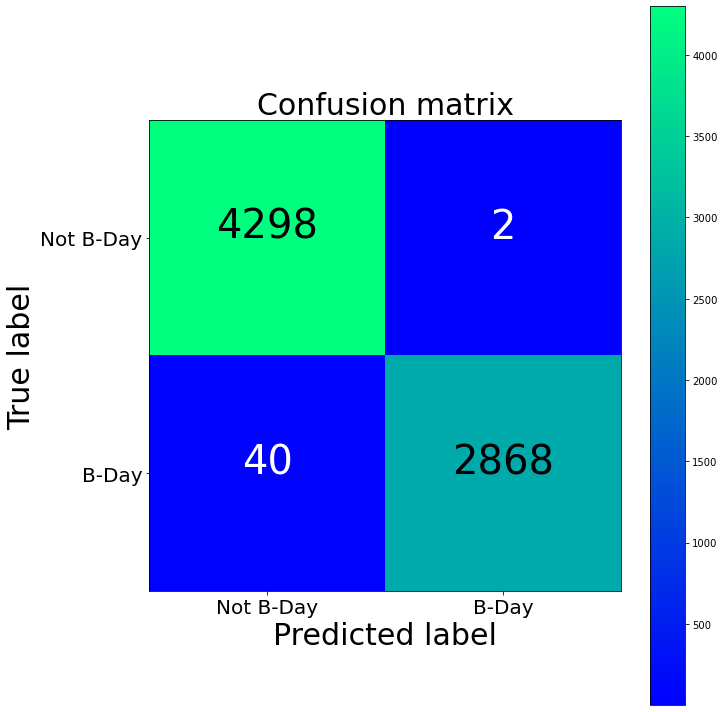

In [76]:
# plot confusion matrix for threshold = 0.8
y_predicted_counts_proba = clf_tfidf.predict_proba(X_test_tfidf)
y_proba = np.array([1 if x >= 0.8 else 0 for x in y_predicted_counts_proba[:,1]])

cm2 = confusion_matrix(y_test, y_proba)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

###  SVM

In [77]:
# use SVM classifier 
clf_svc_tf = SVC(C=10, random_state=40, kernel='linear', verbose=2)
clf_svc_tf.fit(X_train_tfidf, y_train)

[LibSVM]

SVC(C=10, kernel='linear', random_state=40, verbose=2)

In [78]:
# test
y_predicted_counts_svc_tf = clf_svc_tf.predict(X_test_tfidf)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_test, y_predicted_counts_svc_tf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 0.997, precision = 0.997, recall = 0.997, f1 = 0.997,  roc_auc = 0.997


In [79]:
# train
y_train_pred_svc_tf = clf_svc_tf.predict(X_train_tfidf)
accuracy, precision, recall, f1, roc_auc = get_metrics(y_train, y_train_pred_svc_tf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f,  roc_auc = %.3f" % (accuracy, precision, recall, f1, roc_auc))

accuracy = 1.000, precision = 1.000, recall = 1.000, f1 = 1.000,  roc_auc = 1.000


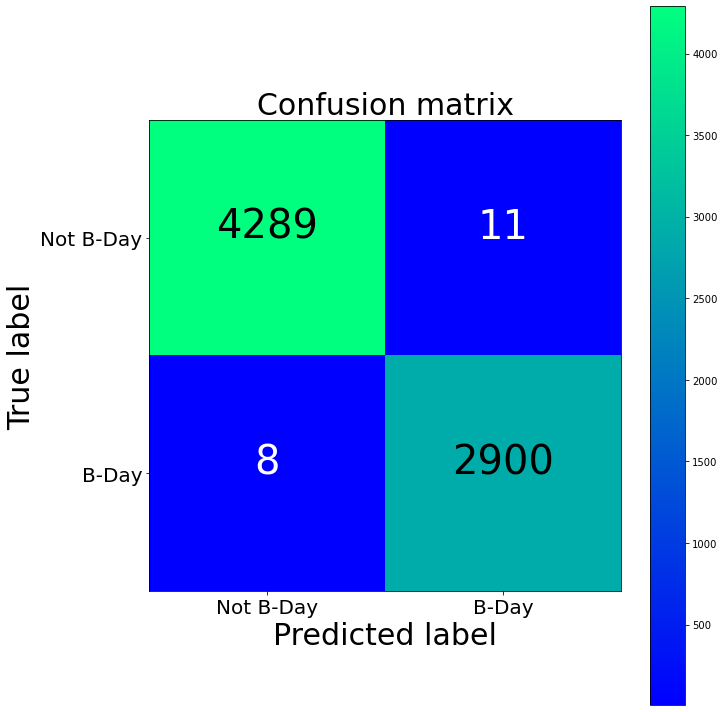

In [80]:
# plot confusion matrix for threshold = 0.5
cm2 = confusion_matrix(y_test, y_predicted_counts_svc_tf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

## Word2Vec

In [54]:
from gensim.models import word2vec


In [57]:
# use Word2Vec
model = word2vec.Word2Vec(data_train['tokens'], vector_size=300, window=3, workers=4)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [58]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [59]:
# create embeddings 
X_train_word2vec = get_word2vec_embeddings(w2v, data_train)
y_train_word2vec = y_train

X_test_word2vec = get_word2vec_embeddings(w2v, data_test)
y_test_word2vec = y_test


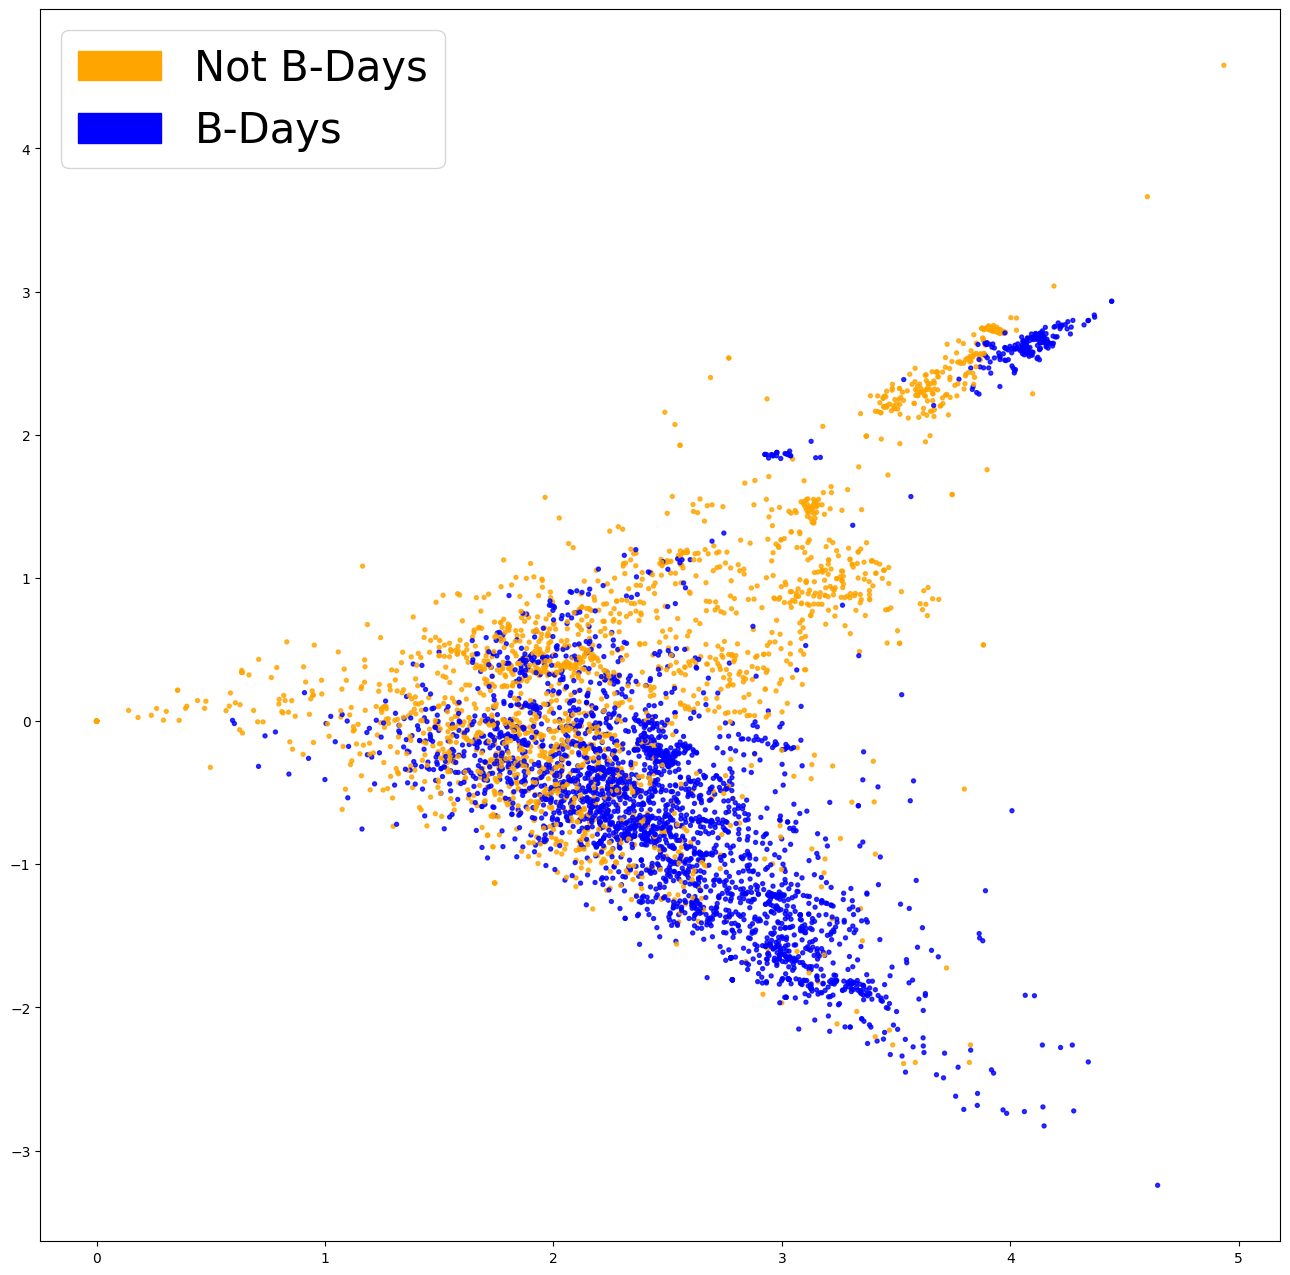

In [60]:
# plot distribution
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_word2vec, y_train_word2vec)
plt.show()

### Log Reg

In [61]:
# use logistic regression classifier
clf_w2v = LogisticRegression(C=10, max_iter=5000,
                         multi_class='ovr', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [62]:
y_predicted_word2vec_train = clf_w2v.predict(X_train_word2vec)

In [63]:
# test
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, roc_auc_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, roc_auc = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec, roc_auc_word2vec))

accuracy = 0.820, precision = 0.820, recall = 0.820, f1 = 0.820, roc_auc = 0.814


In [64]:
# train
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, roc_auc_word2vec = get_metrics(y_train_word2vec, y_predicted_word2vec_train)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, roc_auc = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec, roc_auc_word2vec))

accuracy = 0.828, precision = 0.827, recall = 0.828, f1 = 0.827, roc_auc = 0.819


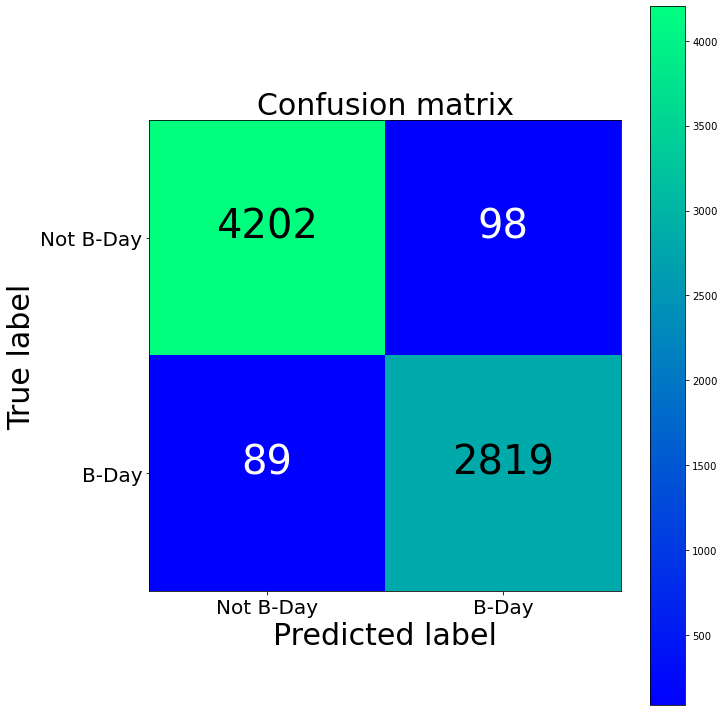

In [91]:
# plot confusion matrix for threshold = 0.5
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()

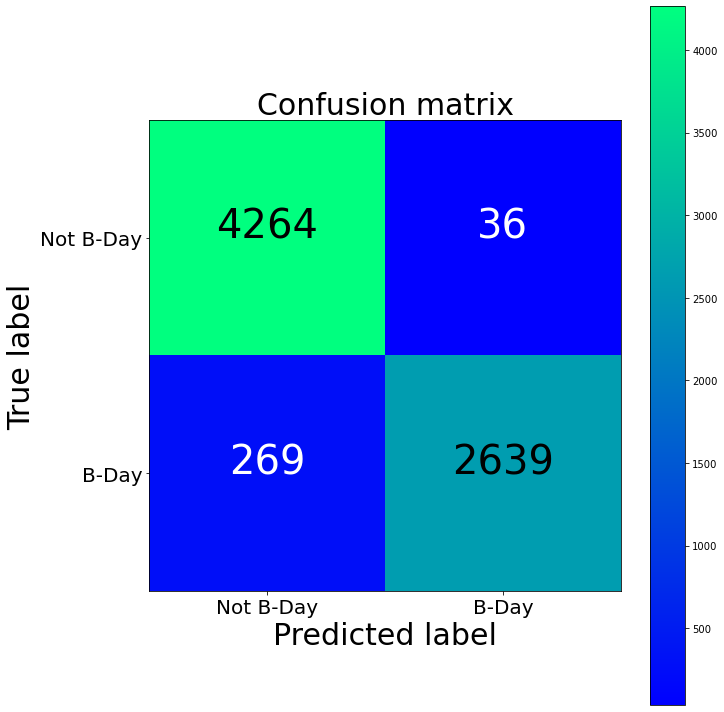

In [92]:
# plot confusion matrix for threshold = 0.8
y_predicted_counts_proba = clf_w2v.predict_proba(X_test_word2vec)
y_proba = np.array([1 if x >= 0.8 else 0 for x in y_predicted_counts_proba[:,1]])

cm2 = confusion_matrix(y_test, y_proba)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Not B-Day','B-Day'], normalize=False, title='Confusion matrix')
plt.show()